[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


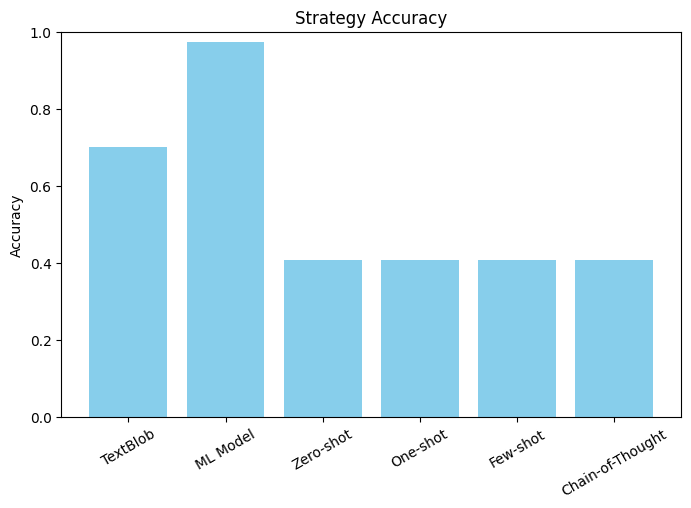

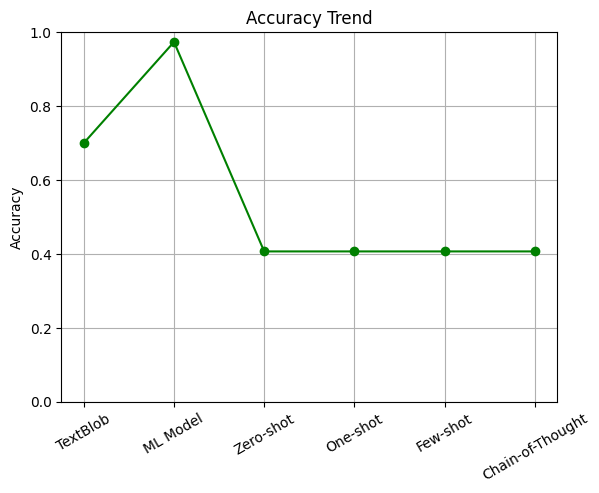

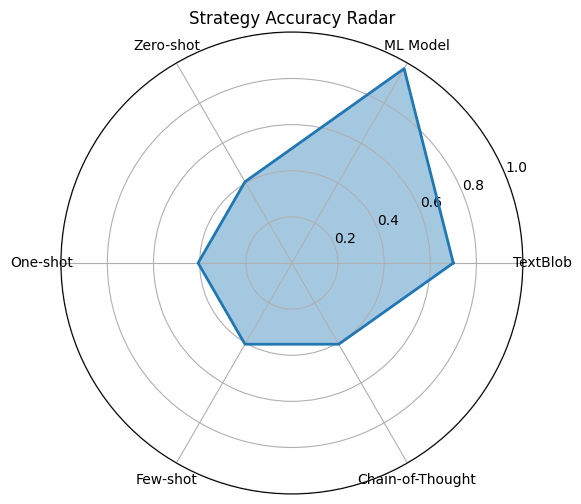

/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1054: UserWarning: Expected 1 arguments for function <function chat_response at 0x7ea4a4e18680>, received 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1062: UserWarning: Expected maximum 1 arguments for function <function chat_response at 0x7ea4a4e18680>, received 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1054: UserWarning: Expected 1 arguments for function <function chat_response at 0x7ea4a4e18720>, received 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1062: UserWarning: Expected maximum 1 arguments for function <function chat_response at 

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://678491636fd327fdd6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
# Install necessary packages (for Colab)
!pip install -q textblob matplotlib scikit-learn pandas nltk gradio seaborn openpyxl

#  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from math import pi
import re
import gradio as gr

#  Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

#  Load Dataset
file_path = "/content/extended_sample_reviews.csv"  # Make sure this file exists in Colab

df = pd.read_csv(file_path)
assert 'review' in df.columns and 'sentiment' in df.columns, "Required columns missing!"
df['cleaned_review'] = df['review'].str.lower().str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)

#  TextBlob Sentiment Analysis (NLP technique)
def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['TextBlob_pred'] = df['cleaned_review'].apply(textblob_sentiment)

#  ML-Based Classifier (CountVectorizer + Naive Bayes)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

model = MultinomialNB()
model.fit(X, y)

def ml_predict(text):
    text_vec = vectorizer.transform([text])
    return model.predict(text_vec)[0]

df['ML_pred'] = df['cleaned_review'].apply(ml_predict)

# Simulated Prompt Strategies (rule-based logic)
def zero_shot(text):
    if any(word in text for word in ["love", "amazing", "great"]):
        return "Positive"
    elif any(word in text for word in ["worst", "bad", "hate"]):
        return "Negative"
    else:
        return "Neutral"

def one_shot(text):
    return zero_shot(text)

def few_shot(text):
    return zero_shot(text)

def chain_of_thought(text):
    if "not" in text and "good" in text:
        return "Negative"
    elif "okay" in text or "fine" in text:
        return "Neutral"
    else:
        return zero_shot(text)

# Evaluate all strategies
strategies = {
    'TextBlob': df['TextBlob_pred'].tolist(),
    'ML Model': df['ML_pred'].tolist(),
    'Zero-shot': df['cleaned_review'].apply(zero_shot).tolist(),
    'One-shot': df['cleaned_review'].apply(one_shot).tolist(),
    'Few-shot': df['cleaned_review'].apply(few_shot).tolist(),
    'Chain-of-Thought': df['cleaned_review'].apply(chain_of_thought).tolist()
}

labels = df['sentiment'].tolist()
results = {}

for name, preds in strategies.items():
    acc = accuracy_score(labels, preds)
    results[name] = acc
    df[name + '_pred'] = preds

# Accuracy Visualizations
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("Strategy Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# Line chart
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='-', color='green')
plt.title("Accuracy Trend")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.show()

# Radar Chart
techniques = list(results.keys())
scores = list(results.values())
scores += scores[:1]
angles = [n / float(len(techniques)) * 2 * pi for n in range(len(techniques))]
angles += angles[:1]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], techniques)
ax.plot(angles, scores, linewidth=2, linestyle='solid')
ax.fill(angles, scores, alpha=0.4)
plt.title('Strategy Accuracy Radar')
plt.show()

#  Chatbot (Gradio)
def chat_response(user_input):
    try:
        query = user_input.lower()

        if "how many" in query:
            if "positive" in query:
                count = len(df[df['sentiment'].str.lower() == 'positive'])
                return f"✅ There are {count} positive reviews."
            elif "negative" in query:
                count = len(df[df['sentiment'].str.lower() == 'negative'])
                return f"❌ There are {count} negative reviews."
            elif "neutral" in query:
                count = len(df[df['sentiment'].str.lower() == 'neutral'])
                return f"➖ There are {count} neutral reviews."

        elif "show" in query:
            if "positive" in query:
                return "\n".join(df[df['sentiment'].str.lower() == 'positive']['review'].head(3).tolist())
            elif "negative" in query:
                return "\n".join(df[df['sentiment'].str.lower() == 'negative']['review'].head(3).tolist())
            elif "neutral" in query:
                return "\n".join(df[df['sentiment'].str.lower() == 'neutral']['review'].head(3).tolist())

        elif "search" in query:
            keyword = query.split("search")[-1].strip()
            matches = df[df['review'].str.lower().str.contains(keyword)]
            if not matches.empty:
                return "\n".join(matches['review'].head(5).tolist())
            else:
                return "❗ No matching reviews found."

        return "❓ Try asking: How many positive reviews, Show negative reviews, Search camera"

    except Exception as e:
        return f"🚫 Error: {str(e)}"

# 🟢 Launch chatbot
gr.ChatInterface(
    fn=chat_response,
    title=" Dataset-Based Sentiment Chatbot",
    examples=["How many positive reviews?", "Show negative reviews", "Search camera"]
).launch()
